In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np

In [2]:
test_wav = np.load("TrainValTest/all_wav.npy")
torch.manual_seed(123)
np.random.seed(123)
#attention à ce que les données chargées soit bien des données qui n'ait pas été utilisées pour l'entrainement

# A. Chargement de modèles 

In [3]:
from downloader import SpectroDataset
from downloader import SpectroDataset4D
import models.simpleAE as AE
import models.vanillaVAE as VAE
import models.modules.bottleneck as BN
import models.modules.CNNdecoder as CNNdec
import models.modules.CNNencoder as CNNenc
import models.VAEcharly as VAEcharly


import importlib as implib


### Modèle 1 : AE1D

In [4]:
#chargement modèle
model1 = AE.AE1D(32)
state_dic = torch.load("modelsParam/AE1D/ep5AE1D.pth")
model1.load_state_dict(state_dic)

#chargement données
spectros1 = SpectroDataset(test_wav)
valid_loader1 = DataLoader(spectros1,batch_size=16,shuffle=False)

### Modèle 2 : AE2D

In [5]:
#chargement modèle
model2= AE.AE2D(64)
state_dic = torch.load("modelsParam/AE2D/ep5AE2D.pth")
model2.load_state_dict(state_dic)

#chargement données
spectros2 = SpectroDataset4D(test_wav)
valid_loader2 = DataLoader(spectros2,batch_size=16,shuffle=False)

### Modèle 3 : vanillaVAE

In [6]:
#chargement modèle
vencoder = CNNenc.vanillaEncoder(64)
vbottleneck = BN.VariationalBottleneck(64)
vdecoder = CNNdec.vanillaDecoder(64)
model3 = VAE.vanillaVAE(encoder=vencoder,
                        bottleneck=vbottleneck,
                        reconstructor = vdecoder, 
                        beta = 1)
state_dic = torch.load("modelsParam/vanilla/ep5vanillaVAE_cluster.pth")
model3.load_state_dict(state_dic)

#chargement données
spectros3 = SpectroDataset4D(test_wav)
valid_loader3 = DataLoader(spectros3,batch_size=16,shuffle=False)

### Modèle 4 : charlyVAE

In [7]:
#chargement modèle
encoder = CNNenc.ConvolutionalEncoder(128)
bottleneck = BN.VariationalBottleneck(128)
decoder = CNNdec.ConvolutionalDecoder(128)
model4 = VAEcharly.VAECharly(encoder=encoder, bottleneck=bottleneck, reconstructor=decoder, beta=1)
state_dic = torch.load("modelsParam/charlyVAE/AE_epoch76.stdc", map_location=torch.device('cpu'))
model4.load_state_dict(state_dic)

#chargement données
spectros4 = SpectroDataset4D(test_wav)
valid_loader4 = DataLoader(spectros4,batch_size=16,shuffle=False)

# B. Comparaisons de modèle

## 1. verification comparabilité des modèles 

#### même nombre de paramètres

In [36]:
#nombre de paramètres du modèle
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [49]:
print(count_parameters(model1))
print(count_parameters(model2))
print(count_parameters(model3))

41845
979424
6175488


#### Entrainement similaire (même nb d'epochs, batch, lr, nb de données, etc...)

## 2. Visualisation des reconstructions et comparaisons 2 à 2 de modèles 

In [8]:
batch1 = next(iter(valid_loader1))
batch2 = next(iter(valid_loader2))
batch3 = next(iter(valid_loader3))
batch4 = next(iter(valid_loader4))

recon1 = model1(batch1)
recon2 = model2(batch2)
recon3 = model3(batch3)
recon4 = model4(batch4)

__________SPECTRO n° 1  :   _______________
Spectro original :


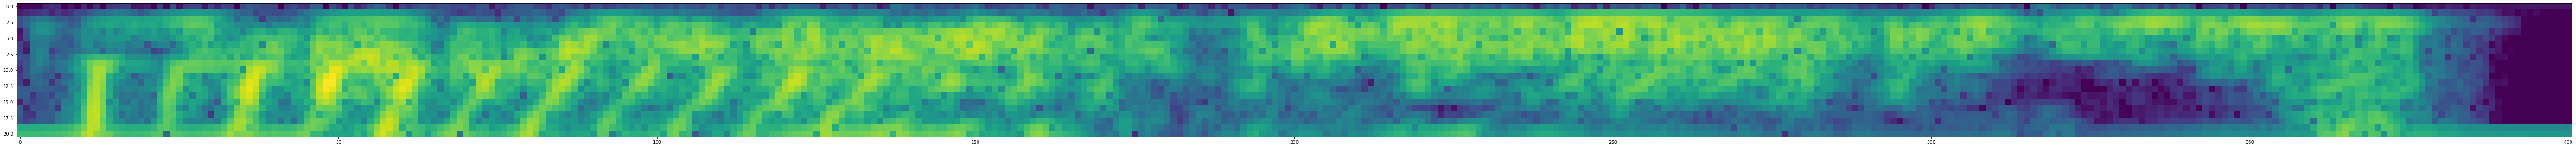

Reconstruction 1 :


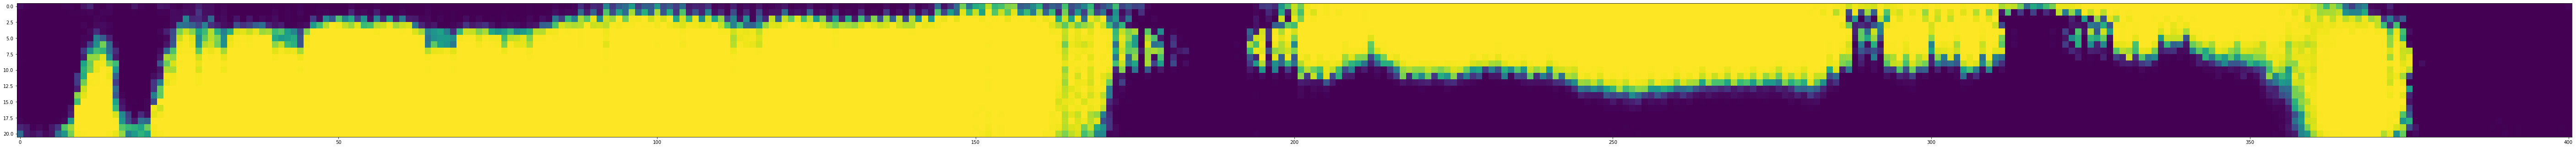

Reconstruction 2 :


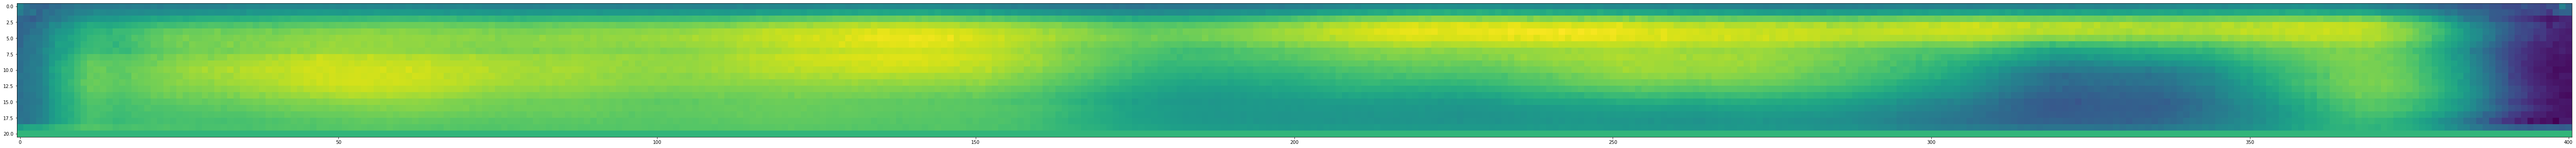

Reconstruction 3 :


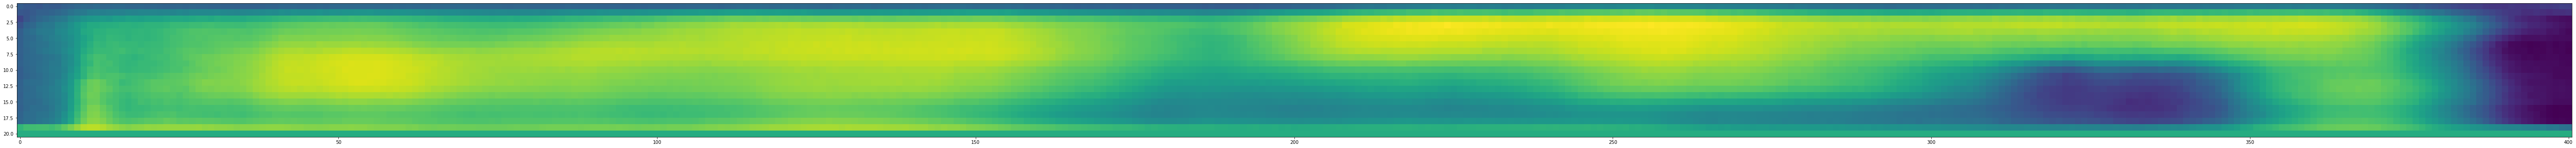

Reconstruction charly :


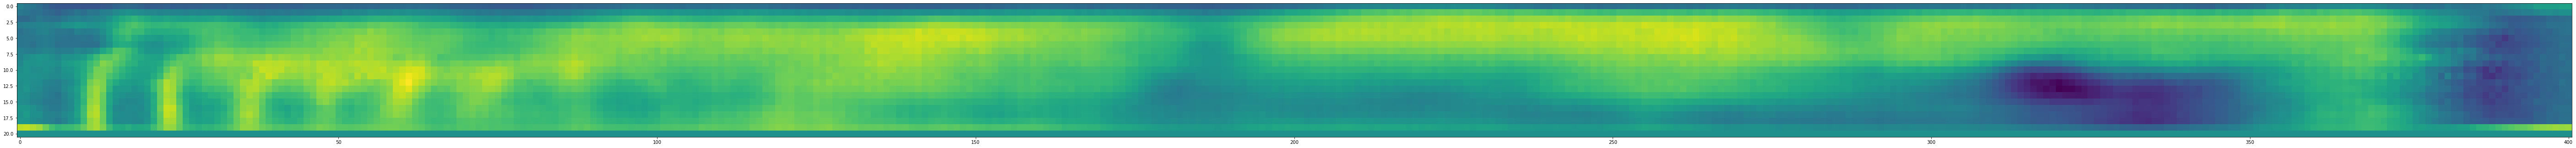

__________SPECTRO n° 2  :   _______________
Spectro original :


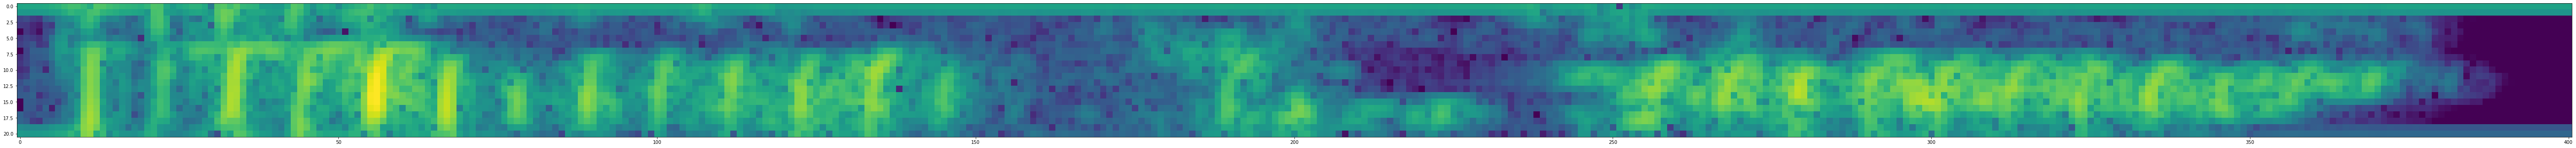

Reconstruction 1 :


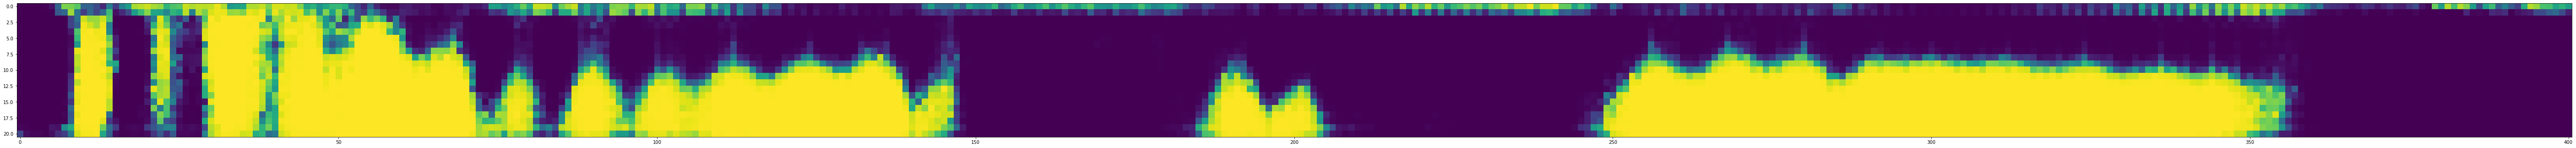

Reconstruction 2 :


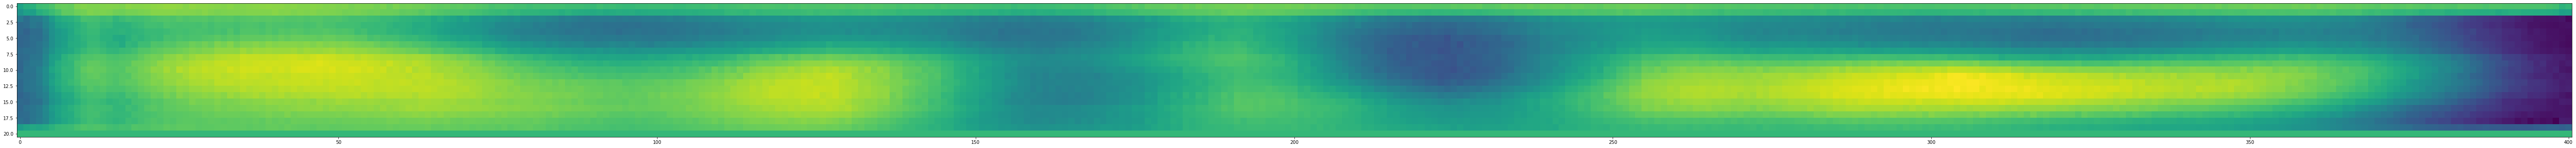

Reconstruction 3 :


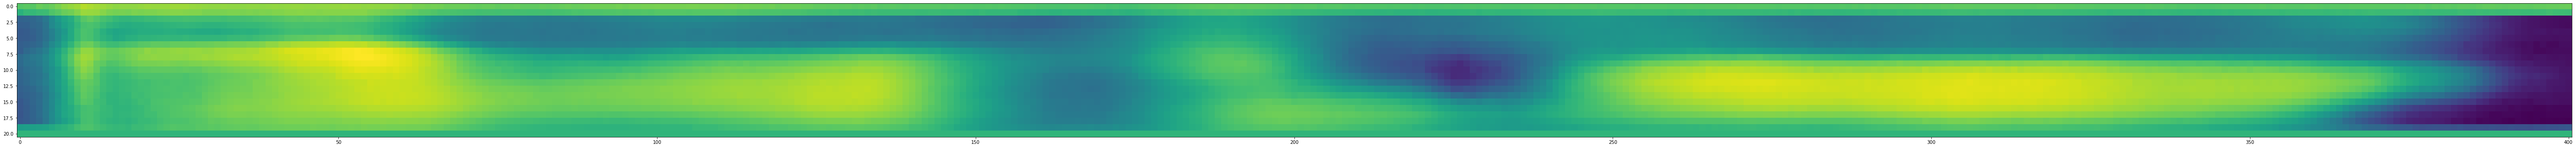

Reconstruction charly :


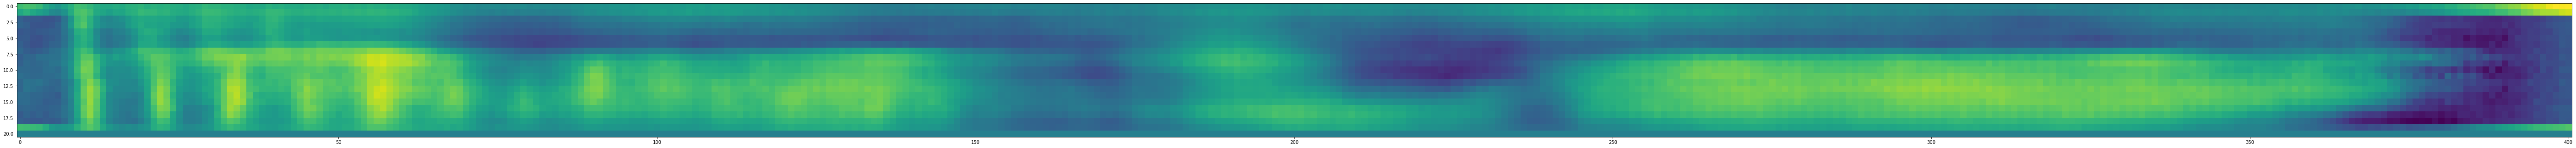

__________SPECTRO n° 3  :   _______________
Spectro original :


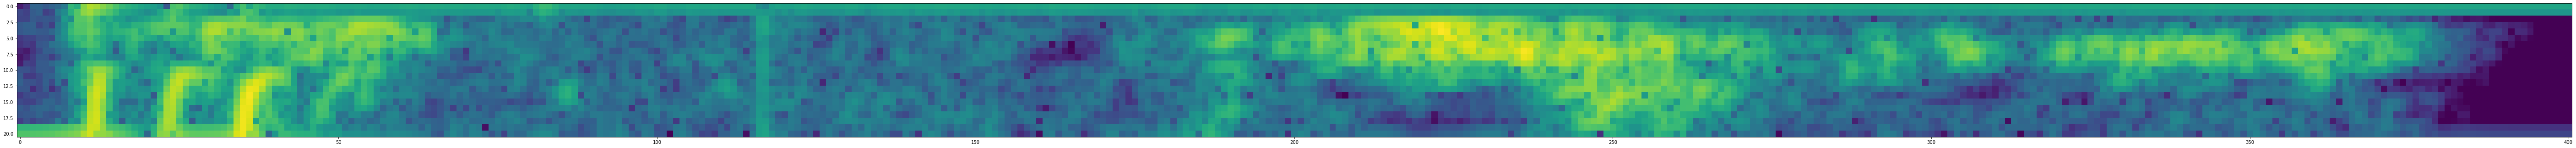

Reconstruction 1 :


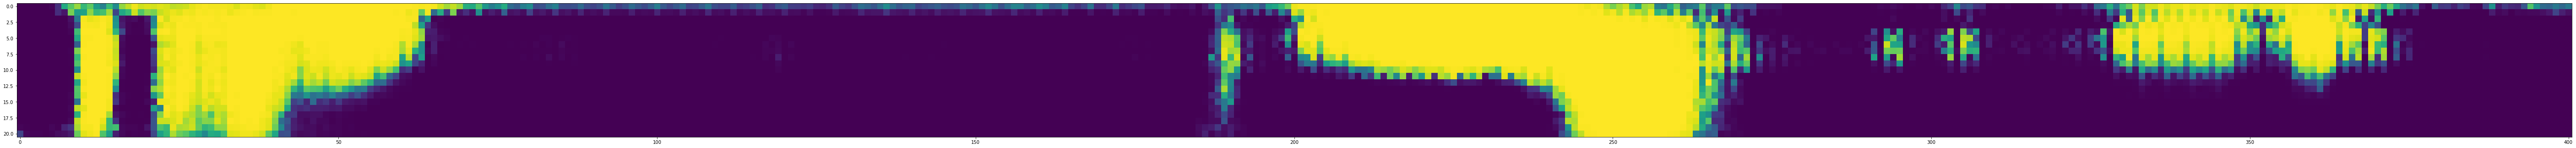

Reconstruction 2 :


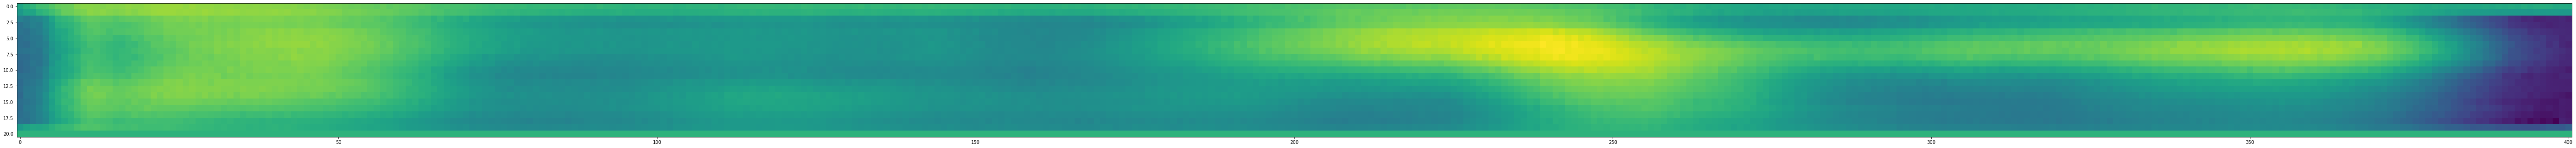

Reconstruction 3 :


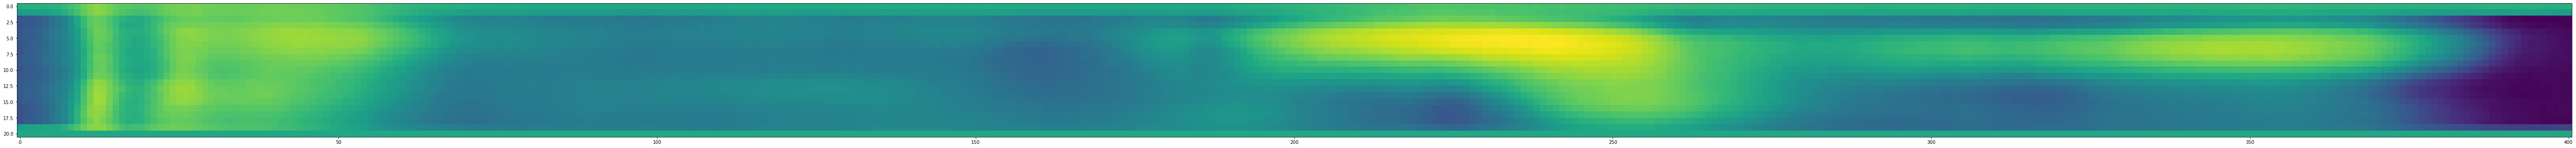

Reconstruction charly :


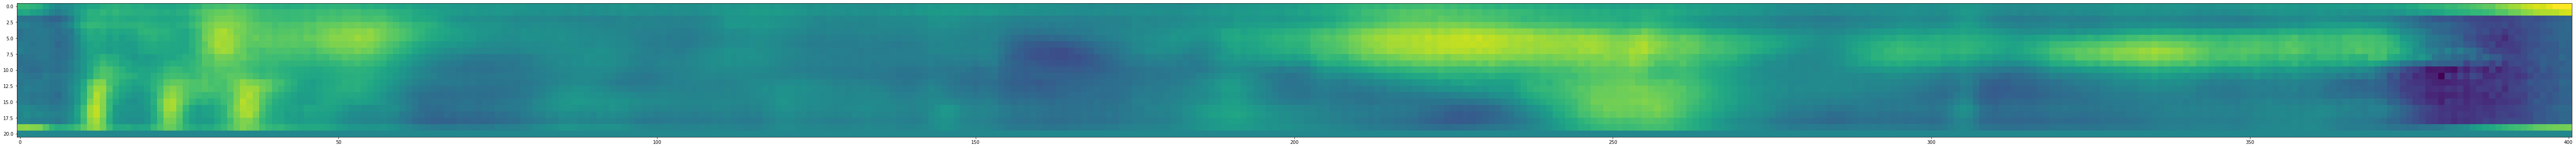

In [10]:
import matplotlib.pyplot as plt

#affichage des reocnstruction et des spectros originaux 
plt.rcParams['figure.figsize'] = [100, 50]
for i in range(3):
    print('__________SPECTRO n°',i+1,' :   _______________')
    print('Spectro original :')
    plt.imshow(np.transpose(batch2[i][0].detach().numpy()))
    plt.show()
    print('Reconstruction 1 :')
    plt.imshow(recon1[i].detach().numpy())
    plt.show()
    print('Reconstruction 2 :')
    plt.imshow(np.transpose(recon2[i][0].detach().numpy()))
    plt.show()
    print('Reconstruction 3 :')
    plt.imshow(np.transpose(recon3['logits'][i][0].detach().numpy()))
    plt.show()
    print('Reconstruction charly :')
    plt.imshow(np.transpose(recon4['logits'][i][0].detach().numpy()))
    plt.show()


Pourquoi le 1D et le 2D se comporte t-il comme ça ? le 1D est beaucoup moins blurry temporellement car il se concentre uniquement sur la reconstruction temporelle, sans se soucier de reconcilier les différentes fréquences ensembles.
Et comme le son est avant tout temporelle, c'est pas si inintéressant non ?

## 3. Etude des espaces latents construits